In [1]:
# !pip install kagglehub
# import kagglehub

# # Download latest version
# path = kagglehub.dataset_download("nmtclone/rsna-ich-mil")

# print("Path to dataset files:", path)
# # Move from src to des
# src = path + "/rsna-ich-mil/"
# dest = "/root/rsna-ich-mil/"

# mv = "mv " + src + " " + dest
# mv

# Import Libraries

In [2]:
!pip install gpytorch torchsummary iterative-stratification optuna pytorch_metric_learning wandb
!pip install torch pydicom pandas scikit-learn scikit-image numpy opencv-python matplotlib

In [38]:
import optuna
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
import wandb
import time

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
import torch.nn.functional as F
from torchvision.transforms import v2 as transforms
from pytorch_metric_learning import losses
# from torch.cpu.amp import GradScaler

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import roc_curve, auc, confusion_matrix, ConfusionMatrixDisplay, roc_auc_score, multilabel_confusion_matrix

import sys
sys.path.append('../')

from models.mil_resnet import CNN_ATT_GP_Multilabel, CNN_ATT_GP, CNN_ATT_GP_MIML
from utils import hard_negative_mining as hnm
import gpytorch
from layers.gaussian_process import SingletaskGPModel, PGLikelihood
from utils.early_stopping import EarlyStoppingForOptimization, EarlyStopping

os.environ['PYTORCH_CUDA_ALLOC_CONF'] = 'expandable_segments:True'
import gc
torch.cuda.empty_cache()
gc.collect()

38871

In [4]:
import warnings
from sklearn.exceptions import UndefinedMetricWarning

warnings.filterwarnings("ignore", category=RuntimeWarning)
warnings.filterwarnings("ignore", category=UndefinedMetricWarning)

# Configurations
## GPU Configurations

In [5]:
# Initialize GPU Device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)} is available.")
else:
    print("No GPU available. Training will run on CPU.")

print(device)

GPU: NVIDIA GeForce RTX 4070 SUPER is available.
cuda


In [6]:
%load_ext autoreload
%autoreload 2

## Seed Everything

In [7]:
def seed_everything(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False


seed_everything()

## Constants and Hyperparameters

In [8]:
import yaml

with open("../config.yaml") as file:
    config = yaml.safe_load(file)

# Accessing constants from config
HEIGHT = config['height']
WIDTH = config['width']
CHANNELS = config['channels']

TRAIN_BATCH_SIZE = config['train_batch_size']
VALID_BATCH_SIZE = config['valid_batch_size']
TEST_BATCH_SIZE = config['test_batch_size']
TEST_SIZE = config['test_size']
VALID_SIZE = config['valid_size']

TRAINING_TYPE = config['training_type']
GP_MODEL = config['gp_model']
GP_KERNEL = config['kernel_type']
MODEL_TYPE = config['model_type']
CONTRASTIVE_LEARNING = config['contrastive_learning']

MAX_SLICES = config['max_slices']
SHAPE = tuple(config['shape'])

NUM_EPOCHS = config['num_epochs']
LEARNING_RATE = config['learning_rate']
LEARNING_RATE_NGD = config['learning_rate_ngd']
INDUCING_POINTS = config['inducing_points']
THRESHOLD = config['threshold']

NUM_CLASSES = config['num_classes']

TARGET_LABELS = config['target_labels']

MODEL_PATH = config['model_path']
LIKELIHOOD_PATH = config['likelihood_path']
DEVICE = config['device']

PROJECTION_LOCATION = config['projection_location']
PROJECTION_HIDDEN_DIM = config['projection_hidden_dim']
PROJECTION_OUTPUT_DIM = config['projection_output_dim']

ATTENTION_HIDDEN_DIM = config['attention_hidden_dim']

In [9]:
KAGGLE = os.path.exists(('kaggle/input'))
REMOTE_SERVER = os.path.exists(('/workspace/rsna-ich-mil'))
ROOT_DIR = None
# DATA_DIR = ROOT_DIR + 'rsna-mil-training/' if KAGGLE else '../rsna-ich-mil/'
if KAGGLE:
  DATA_DIR = ROOT_DIR + 'rsna-mil-training/'
  DICOM_DIR = DATA_DIR
  CSV_PATH = DICOM_DIR + 'training_1000_scan_subset.csv'
elif REMOTE_SERVER:
  DATA_DIR = '/root/rsna-ich-mil/'
  DICOM_DIR = DATA_DIR
  CSV_PATH = '/workspace/Brain-Stroke-Diagnosis/rsna/data_analyze/training_dataset_3_redundancy.csv'
  print('Running on remote server.')
else:
  DATA_DIR = '../rsna-ich-mil/'
  DICOM_DIR = DATA_DIR
  CSV_PATH = './data_analyze/training_dataset_3_redundancy.csv'

# CSV_PATH = DICOM_DIR + 'training_1000_scan_subset.csv' if KAGGLE else './data_analyze/training_dataset_2_redundancy.csv'
patient_scan_labels = pd.read_csv(CSV_PATH, nrows=6000)
# patient_scan_labels = pd.read_csv(CSV_PATH)
dicom_dir = DICOM_DIR if KAGGLE else DATA_DIR

In [10]:
patient_scan_labels.head()

,filename,labels,any,epidural,intraparenchymal,intraventricular,subarachnoid,subdural,patient_id,study_instance_uid,...,rescale_intercept,rescale_slope,patient_label,patient_any,patient_subdural,patient_epidural,patient_intraparenchymal,patient_intraventricular,patient_subarachnoid,patient_labels
0,"['ID_45785016b.dcm', 'ID_37f32aed2.dcm', 'ID_1...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",ID_0002cd41,ID_66929e09d4,...,"[-1024.0, -1024.0, -1024.0, -1024.0, -1024.0, ...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",0,0,0,0,0,0,0,0
1,"['ID_138d275c8.dcm', 'ID_447fa09d9.dcm', 'ID_0...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",ID_00054f3f,ID_8a449ae31b,...,"[-1024.0, -1024.0, -1024.0, -1024.0, -1024.0, ...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",0,0,0,0,0,0,0,0
2,"['ID_c6f9f68c9.dcm', 'ID_520df89aa.dcm', 'ID_b...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",ID_0006d192,ID_25690b4725,...,"[-1024.0, -1024.0, -1024.0, -1024.0, -1024.0, ...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",0,0,0,0,0,0,0,0
3,"['ID_31b14de96.dcm', 'ID_203ef1efe.dcm', 'ID_9...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",ID_00086119,ID_fdde2979b0,...,"[-1024.0, -1024.0, -1024.0, -1024.0, -1024.0, ...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",0,0,0,0,0,0,0,0
4,"['ID_0785539ea.dcm', 'ID_30c100dbc.dcm', 'ID_3...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",ID_000e5623,ID_9a4be35b9a,...,"[-1024.0, -1024.0, -1024.0, -1024.0, -1024.0, ...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",0,0,0,0,0,0,0,0


# Data Preprocessing
## Splitting Data

In [11]:
def split_dataset(patient_scan_labels, test_size=TEST_SIZE, val_size=VALID_SIZE, random_state=42):
    # Extract the labels from the DataFrame
    labels = patient_scan_labels['patient_label']
    if test_size > 0:
        # First, split off the test set
        train_val_labels, test_labels = train_test_split(
            patient_scan_labels,
            test_size=test_size,
            stratify=labels,
            random_state=random_state
        )

        # Calculate the validation size relative to the train_val set
        val_size_adjusted = val_size / (1 - test_size)

        # Split the train_val set into train and validation sets
        train_labels, val_labels = train_test_split(
            train_val_labels,
            test_size=val_size_adjusted,
            stratify=train_val_labels['patient_label'],
            random_state=random_state
        )
    else:
        train_labels, val_labels = train_test_split(
            patient_scan_labels,
            test_size=val_size,
            stratify=labels,
            random_state=random_state
        )
        test_labels = None

    return train_labels, val_labels, test_labels

from sklearn.model_selection import train_test_split
from iterstrat.ml_stratifiers import MultilabelStratifiedShuffleSplit
import numpy as np

def split_dataset_for_multilabel(patient_scan_labels, test_size=0.15, val_size=0.25, random_state=42):
    # Extract the labels from the DataFrame
    labels = patient_scan_labels[['patient_any', 'patient_epidural', 'patient_intraparenchymal',
                                  'patient_intraventricular', 'patient_subarachnoid', 'patient_subdural']].values

    if test_size > 0:
        # First split: train + test
        msss = MultilabelStratifiedShuffleSplit(n_splits=1, test_size=test_size, random_state=random_state)
        train_idx, test_idx = next(msss.split(patient_scan_labels, labels))

        train_labels = patient_scan_labels.iloc[train_idx]
        test_labels = patient_scan_labels.iloc[test_idx]

        # Second split: train + validation
        msss_val = MultilabelStratifiedShuffleSplit(n_splits=1, test_size=val_size, random_state=random_state)
        train_idx, val_idx = next(msss_val.split(train_labels, labels[train_idx]))

        train_labels_final = train_labels.iloc[train_idx]
        val_labels = train_labels.iloc[val_idx]

    else:
        # Only split into train and validation if test_size is 0
        msss_val = MultilabelStratifiedShuffleSplit(n_splits=1, test_size=val_size, random_state=random_state)
        train_idx, val_idx = next(msss_val.split(patient_scan_labels, labels))

        train_labels_final = patient_scan_labels.iloc[train_idx]
        val_labels = patient_scan_labels.iloc[val_idx]
        test_labels = None

    return train_labels_final, val_labels, test_labels

## Dataset Augmentor

In [12]:
class DatasetAugmentor:
    def __init__(self, height, width, levels=2, seed=None):
        self.height = height
        self.width = width
        self.levels = levels  # Dynamic number of levels
        self.seed = seed
        self.params = []

        # Create different levels of transforms based on the number of levels specified
        for i in range(levels):
            factor = (i + 1) / levels
            self.params.append(
                self._create_transform(
                    degrees=int(15 * factor),
                    translate_range=(0.2 * factor, 0.2 * factor),
                    scale_range=(1 - 0.2 * factor, 1 + 0.2 * factor),
                    brightness_range=0.2 * factor,
                    contrast_range=0.2 * factor,
                    blur_sigma_range=(0.5 * factor, 1.0 * factor),
                    apply_elastic=(i >= levels // 2),
                    level_name=f'level_{i + 1}'
                )
            )

    def _sample_value(self, value_range):
        if isinstance(value_range, tuple):
            random.seed(self.seed)
            return random.uniform(value_range[0], value_range[1])
        return value_range

    def _create_transform(self, degrees, translate_range, scale_range, brightness_range, contrast_range, blur_sigma_range, apply_elastic, level_name):
        print(f"Creating '{level_name}' transform with parameters:")
        sampled_values = {
            "degrees": abs(self._sample_value((-degrees, degrees))),
            "translate": (abs(self._sample_value(translate_range[0])), abs(self._sample_value(translate_range[1]))),
            "scale": self._sample_value(scale_range),
            "brightness": self._sample_value(brightness_range),
            "contrast": self._sample_value(contrast_range),
            "blur_sigma": self._sample_value(blur_sigma_range),
            "apply_elastic": apply_elastic
        }

        print(sampled_values)
        return sampled_values

    def apply_transform(self, image, level):
        params = self.params[level]
        transform = self._get_transform(params, channels=image.shape[0])
        return transform(image)

    def _get_transform(self, params, channels=3):
        transform_list = [
            transforms.ToPILImage(),
            transforms.RandomHorizontalFlip(p=0.5),
            transforms.RandomAffine(degrees=params["degrees"], translate=params["translate"], scale=(params["scale"], params["scale"])),
            transforms.ColorJitter(brightness=params["brightness"], contrast=params["contrast"]),
            transforms.GaussianBlur(kernel_size=(3, 3), sigma=params["blur_sigma"]),
            transforms.RandomApply([transforms.ElasticTransform()] if params["apply_elastic"] else [], p=0.3),
            transforms.Resize(256),
            transforms.CenterCrop(self.height),
            transforms.Compose([transforms.ToImage(), transforms.ToDtype(torch.float32, scale=True)])
        ]

        # if channels == 3:
        #     transform_list.extend([
        #         transforms.Normalize(mean=[0.16774411, 0.1360026, 0.19076315], std=[0.3101935, 0.27605791, 0.30469988]),
        #         transforms.RandomApply([self._channel_shuffle], p=0.3)
        #     ])
        # elif channels == 1:
        #     transform_list.append(transforms.Normalize(mean=[0.16774411], std=[0.3101935]))

        return transforms.Compose(transform_list)

    def _channel_shuffle(self, tensor):
        torch.manual_seed(self.seed)
        channels = tensor.shape[0]
        indices = torch.randperm(channels)
        return tensor[indices]

## Dataset Generator

In [13]:
from dataset_generators.RSNA_Dataset import MedicalScanDataset

In [14]:
class TrainDatasetGenerator(MedicalScanDataset):
    """Dataset class for training medical scan data."""

    def __init__(self, data_dir, patient_scan_labels, augmentor=None):
        super().__init__(data_dir, patient_scan_labels, augmentor)


class TestDatasetGenerator(MedicalScanDataset):
    """Dataset class for testing medical scan data."""

    def __init__(self, data_dir, patient_scan_labels, augmentor=None):
        super().__init__(data_dir, patient_scan_labels, augmentor)

In [15]:
augmentor = DatasetAugmentor(HEIGHT, WIDTH, levels=1, seed=42)

Creating 'level_1' transform with parameters:
{'degrees': 4.182803953736514, 'translate': (0.2, 0.2), 'scale': 1.0557707193831534, 'brightness': 0.2, 'contrast': 0.2, 'blur_sigma': 0.8197133992289418, 'apply_elastic': True}


In [16]:
original_dataset = TrainDatasetGenerator(dicom_dir, patient_scan_labels, augmentor=None)

In [17]:
len(original_dataset)

6000

In [18]:
x, y, z, _ = original_dataset[0]
print(x.shape, y.shape, z.shape)

torch.Size([28, 1, 224, 224]) torch.Size([28]) torch.Size([])


In [19]:
def get_train_loader(dicom_dir, patient_scan_labels, batch_size=TRAIN_BATCH_SIZE):
    # original_dataset = TrainDatasetGenerator(dicom_dir, patient_scan_labels, augmentor=augmentor)
    original_dataset = TrainDatasetGenerator(dicom_dir, patient_scan_labels, augmentor=None)
    return DataLoader(original_dataset, batch_size=batch_size, shuffle=True, num_workers=8, pin_memory=True, drop_last=True)

def get_test_loader(dicom_dir, patient_scan_labels, batch_size=TEST_BATCH_SIZE):
    test_dataset = TestDatasetGenerator(dicom_dir, patient_scan_labels, augmentor=None)
    return DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=8, pin_memory=True)

# Utils
## Augment batch for CL

In [20]:
# Version 2: Avg time taken: 0.05 seconds for 1 augmentation (w ResizedCrop)
def augment_batch(batch_images):
    if CHANNELS == 1:
        batch_size, num_instances, channels, height, width = batch_images.shape
    else:
        batch_size, num_instances, height, width, channels = batch_images.shape

    # Define augmentation transformations using GPU-compatible operations
    aug_transform = transforms.Compose([
        transforms.RandomResizedCrop((height, width), scale=(0.8, 1.1)),
        transforms.RandomApply([transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4, hue=0.4)], p=0.6),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.Compose([transforms.ToImage(), transforms.ToDtype(torch.float32, scale=True)]),
    ])

    # Apply transformations directly on the tensor without converting to PIL
    augmented_batch = torch.empty_like(batch_images)  # Preallocate memory for augmented images

    for i in range(batch_size):
        for j in range(num_instances):
            if CHANNELS == 1:
                augmented_batch[i, j] = aug_transform(batch_images[i, j])
            else:
                augmented_batch[i, j] = aug_transform(batch_images[i, j].permute(2, 0, 1)).permute(1, 2, 0)

    return augmented_batch.cuda()  # Move the augmented batch to GPU

## NTXentLoss

In [21]:
class NTXentLoss(losses.NTXentLoss):
    def __init__(self, temperature, **kwargs):
        super().__init__(temperature=temperature, **kwargs)
        self.temperature = temperature

    def forward(self, embeddings, labels=None, hard_pairs=None):
        # Normalize feature vectors
        feature_vectors_normalized = F.normalize(embeddings, p=2, dim=1)

        if labels == None:
            # Self-supervised labels
            batch_size = feature_vectors_normalized.size(0) // 2  # Assuming equal size for both embeddings
            labels = torch.cat([torch.arange(batch_size), torch.arange(batch_size)], dim=0)

        # Compute logits
        logits = torch.div(
            torch.matmul(
                feature_vectors_normalized, torch.transpose(feature_vectors_normalized, 0, 1)
            ),
            self.temperature,
        )

        if labels == None:
            return losses.NTXentLoss(temperature=self.temperature)(logits, torch.squeeze(labels))
        if hard_pairs == None:
            return losses.SupConLoss(temperature=self.temperature)(logits, torch.squeeze(labels))
        return losses.SupConLoss(temperature=self.temperature)(logits, torch.squeeze(labels), hard_pairs)

# Training and Validation
## Metrics Calculation
### Performance Metrics

In [22]:
def calculate_metrics(predictions, labels):
    """Calculate and return performance metrics."""
    return {
        "accuracy": accuracy_score(labels, predictions),
        "precision": precision_score(labels, predictions, average='macro'),
        "recall": recall_score(labels, predictions, average='macro'),
        "f1": f1_score(labels, predictions, average='macro'),
        "auc": roc_auc_score(labels, predictions)
    }


def print_epoch_stats(epoch, num_epochs, phase, loss, metrics):
    """Print statistics for an epoch."""
    print(f"Epoch {epoch + 1}/{num_epochs} - {phase.capitalize()}:")
    print(f"Loss: {loss:.4f}, Accuracy: {metrics['accuracy']:.4f}, "
          f"Precision: {metrics['precision']:.4f}, Recall: {metrics['recall']:.4f}, "
          f"F1: {metrics['f1']:.4f}, AUC: {metrics['auc']:.4f}")

### Loss Function

In [23]:
def combined_loss(outputs, gp_distribution, target, alpha=0.5):
    if CHANNELS == 1:
        bce_loss_fn = nn.BCEWithLogitsLoss()
        bce_loss = bce_loss_fn(outputs.squeeze(), target.float())
        kl_divergence = gp_distribution.variational_strategy.kl_divergence()
        total_loss = (1 - alpha) * bce_loss + alpha * kl_divergence
    else:
        ce_loss_fn = nn.CrossEntropyLoss()
        ce_loss = ce_loss_fn(outputs.squeeze(), target.float())
        kl_divergence = gp_distribution.variational_strategy.kl_divergence()
        total_loss = (1 - alpha) * ce_loss + alpha * kl_divergence

    return total_loss

## Training Loop

In [24]:
from tqdm import tqdm  # Add this import at the top of your file

def train_epoch(model, likelihoods, data_loader, criterion_cl, criterion_bce, mlls, optimizer, variational_ngd_optimizer, scheduler,
                scaler, device):
    total_loss = 0.0
    total_nlls = 0.0
    alpha = 0.5
    predictions = []
    labels = []

    model.train()
    likelihoods.train()

    # for batch_data, batch_labels, batch_patient_labels, batch_multi_labels in data_loader:
    for batch_data, batch_labels, batch_patient_labels, batch_multi_labels in tqdm(data_loader):
        batch_data = batch_data.to(device)
        batch_patient_labels = batch_patient_labels.float().to(device)
        batch_multi_labels = batch_multi_labels.float().to(device)
        optimizer.zero_grad()

        if GP_MODEL == 'single_task':
            if NUM_CLASSES != 1:
                for i in range(NUM_CLASSES):
                    variational_ngd_optimizer[i].zero_grad()
            else:
                variational_ngd_optimizer.zero_grad()

        if TRAINING_TYPE == 'end_to_end': 
            if CONTRASTIVE_LEARNING:
                aug_data_1 = augment_batch(batch_data)
                aug_data_2 = augment_batch(batch_data)
                batch_data = torch.cat([aug_data_1, aug_data_2], dim=0)
                batch_labels = torch.cat([batch_labels, batch_labels], dim=0)
                batch_multi_labels = torch.cat([batch_multi_labels, batch_multi_labels], dim=0)
                batch_patient_labels = torch.cat([batch_patient_labels, batch_patient_labels], dim=0)
            
            outputs, gp_outputs, att_outputs = model(batch_data)

            if GP_MODEL == 'single_task' and NUM_CLASSES != 1:
                loss = 0
                gp_loss = 0
                ntx_loss = 0 

                for i in range(NUM_CLASSES):
                    gp_loss += -mlls[i](gp_outputs[i], batch_multi_labels[:, i])

                if CONTRASTIVE_LEARNING:
                    miner_func = hnm.ExamplePairMiner()
                    hard_pairs = miner_func(outputs, batch_multi_labels)
                    ntx_loss = criterion_cl(outputs, labels=batch_multi_labels, hard_pairs=hard_pairs)
                    loss = 0.3 * criterion_bce(outputs, batch_multi_labels) + 0.3 * gp_loss + ntx_loss * 0.4 
                else:   
                    loss = 0.5 * criterion_bce(outputs, batch_multi_labels) + 0.5 * gp_loss

                loss = loss.mean()

                probs = [likelihoods[i](gp_outputs[i]).probs for i in range(NUM_CLASSES)]
                probabilities = torch.stack(probs, dim=1)
                preds = (probabilities >= THRESHOLD).int()

            elif GP_MODEL == 'single_task' and NUM_CLASSES == 1:
                if CONTRASTIVE_LEARNING:
                    miner_func = hnm.ExamplePairMiner() 
                    hard_pairs = miner_func(outputs, batch_patient_labels)
                    ntx_loss = criterion_cl(outputs, labels=batch_patient_labels, hard_pairs=hard_pairs)
                    # loss = 0.3 * criterion_bce(outputs.squeeze(-1), batch_patient_labels) + 0.3 * mlls(gp_outputs, batch_patient_labels) + ntx_loss * 0.4
                    loss = ntx_loss * 0.5 + 0.5 * criterion_bce(outputs.squeeze(-1), batch_patient_labels)
                    loss = loss.mean()
                    loss += -mlls(gp_outputs, batch_patient_labels) * 0.5
                else:
                    loss = -mlls(gp_outputs, batch_patient_labels) * 0.5 + 0.5 * criterion_bce(outputs.squeeze(-1), batch_patient_labels)
                    
                loss = loss.mean()
                preds = likelihoods(gp_outputs).probs >= THRESHOLD
                # preds = (torch.sigmoid(outputs) >= THRESHOLD).int()
            else:
                if NUM_CLASSES == 1:
                    loss = -mlls(gp_outputs, batch_patient_labels) * 0.5 + 0.5 * criterion_bce(outputs.squeeze(-1), batch_patient_labels)
                else:
                    loss = -mlls(gp_outputs, batch_multi_labels) * 0.5 + 0.5 * criterion_bce(outputs, batch_multi_labels)
                loss = loss.mean()
                preds = (outputs >= THRESHOLD).int()
                # preds = (torch.sigmoid(outputs) >= THRESHOLD).int()
                preds = likelihoods(gp_outputs).probs >= THRESHOLD

            predictions.extend(preds.cpu().detach().numpy())

            total_loss += loss.item()
            loss.backward()
            optimizer.step()
            if GP_MODEL == 'single_task':
                if NUM_CLASSES != 1:
                    for i in range(NUM_CLASSES):
                        variational_ngd_optimizer[i].step()
                else:
                    variational_ngd_optimizer.step()


        if NUM_CLASSES == 1:
            labels.extend(batch_patient_labels.cpu().numpy())
        else:
            labels.extend(batch_multi_labels.cpu().numpy())


    return total_loss / len(data_loader), predictions, labels


def validate(model, likelihoods, data_loader, criterion_cl, criterion_bce, mlls, device):
    """Validate the model."""
    model.eval()
    likelihoods.eval()

    total_loss = 0.0
    alpha = 0.5
    predictions = []
    labels = []

    with (torch.inference_mode()):
        # for batch_data, batch_labels, batch_patient_labels, batch_multi_labels in data_loader:
        for batch_data, batch_labels, batch_patient_labels, batch_multi_labels in tqdm(data_loader):
            batch_data = batch_data.to(device)
            batch_patient_labels = batch_patient_labels.float().to(device)
            batch_multi_labels = batch_multi_labels.float().to(device)

            if TRAINING_TYPE == 'end_to_end':
                outputs, gp_outputs, att_outputs = model(batch_data)
                if GP_MODEL == 'single_task':
                    loss = 0
                    if NUM_CLASSES != 1:
                        for i in range(NUM_CLASSES):
                            loss += -mlls[i](gp_outputs[i], batch_multi_labels[:, i])
                    
                        loss.mean()
                        loss += 0.5 * criterion_bce(outputs, batch_multi_labels)
                        total_loss += loss.item()

                        probabilities = torch.stack([likelihoods[i](gp_outputs[i]).probs for i in range(NUM_CLASSES)], dim=1)
                        preds = (probabilities >= THRESHOLD).int()
                    else:
                        loss = -mlls(gp_outputs, batch_patient_labels) * 0.5 + 0.5 * criterion_bce(outputs.squeeze(-1), batch_patient_labels)
                        # loss = -mlls(gp_outputs, batch_patient_labels)
                        loss = loss.mean()
                        total_loss += loss.item()
                        preds = likelihoods(gp_outputs).probs >= THRESHOLD
                        # preds = (torch.sigmoid(outputs) >= THRESHOLD).int()
                else:
                    if NUM_CLASSES == 1:
                        loss = -mlls(gp_outputs, batch_patient_labels) * 0.5 + 0.5 * criterion_bce(outputs.squeeze(-1), batch_patient_labels)
                    else:
                        loss = -mlls(gp_outputs, batch_multi_labels) * 0.5 + 0.5 * criterion_bce(outputs, batch_multi_labels)
                    loss = loss.mean()
                    total_loss += loss.item()
                    # preds = (outputs >= THRESHOLD).int()
                    preds = (torch.sigmoid(outputs) >= THRESHOLD).int()

                predictions.extend(preds.cpu().detach().numpy())

            if NUM_CLASSES == 1:
                labels.extend(batch_patient_labels.cpu().numpy())
            else:
                labels.extend(batch_multi_labels.cpu().numpy())
    return total_loss / len(data_loader), predictions, labels


def train_model(model, likelihoods, train_loader, val_loader, criterion_cl, criterion_bce, optimizer, num_epochs, learning_rate,
                device='cuda'):
    """Train the model and return the best model based on validation accuracy."""
    model = model.to(device)
    model.train()
    likelihoods.train()

    # Initialize Early Stopping
    early_stopping = EarlyStopping(patience=10, verbose=True)

    if GP_MODEL == 'single_task':
        if NUM_CLASSES != 1:
            mlls = [gpytorch.mlls.VariationalELBO(likelihoods[i], model.gp_layers[i], num_data=len(train_loader.dataset)) for
                    i in range(NUM_CLASSES)]
            mlls = [mll.to(device) for mll in mlls]

            variational_ngd_optimizer = [
                gpytorch.optim.NGD(model.gp_layers[i].variational_parameters(), num_data=len(train_loader.dataset),
                                   lr=LEARNING_RATE_NGD) for i in range(NUM_CLASSES)]
        else:
            mlls = gpytorch.mlls.VariationalELBO(likelihoods, model.gp_layers, num_data=len(train_loader.dataset))
            mlls = mlls.to(device)
            variational_ngd_optimizer = gpytorch.optim.NGD(model.gp_layers.variational_parameters(), num_data=len(train_loader.dataset),
                                      lr=LEARNING_RATE_NGD)
    else:
        mlls = gpytorch.mlls.VariationalELBO(likelihoods, model.gp_layers, num_data=len(train_loader.dataset))
        mlls = mlls.to(device)
        variational_ngd_optimizer = None

    # scheduler = optim.lr_scheduler.OneCycleLR(optimizer, max_lr=learning_rate, steps_per_epoch=len(train_loader), epochs=num_epochs)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10, eta_min=0.0001)
    # scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[0.5 * num_epochs, 0.75 * num_epochs], gamma=0.1)

    # scaler = torch.amp.GradScaler('cuda')
    scaler = None
    best_val_accuracy = 0.0
    best_model_state = None
    best_likelihood_state = None

    for epoch in range(num_epochs):
        # Training phase
        train_loss, train_predictions, train_labels = train_epoch(model, likelihoods, train_loader, criterion_cl, criterion_bce,
                                                                  mlls, optimizer, variational_ngd_optimizer,
                                                                  scheduler, scaler, device)
        train_metrics = calculate_metrics(train_predictions, train_labels)
        print_epoch_stats(epoch, num_epochs, "train", train_loss, train_metrics)
        # Log training metrics to W&B
        wandb.log({
            "train/loss": train_loss,
            "train/accuracy": train_metrics["accuracy"],
            "train/precision": train_metrics["precision"],
            "train/recall": train_metrics["recall"],
            "train/f1": train_metrics["f1"],
            "train/auc": train_metrics["auc"]
        })

        # Validation phase
        val_loss, val_predictions, val_labels = validate(model, likelihoods, val_loader, criterion_cl, criterion_bce, mlls,
                                                         device)
        val_metrics = calculate_metrics(val_predictions, val_labels)
        print_epoch_stats(epoch, num_epochs, "validation", val_loss, val_metrics)
        # Log validation metrics to W&B
        wandb.log({
            "val/loss": val_loss,
            "val/accuracy": val_metrics["accuracy"],
            "val/precision": val_metrics["precision"],
            "val/recall": val_metrics["recall"],
            "val/f1": val_metrics["f1"],
            "val/auc": val_metrics["auc"]
        })

        # Early Stopping Check
        early_stopping(val_metrics["auc"], model)
        if early_stopping.early_stop:
            print("Early stopping triggered.")
            break

        # Save best model
        if val_metrics['auc'] > best_val_accuracy:
            best_val_accuracy = val_metrics['auc']
            best_model_state = model.state_dict()
            best_likelihood_state = likelihoods.state_dict()

    # Load best model
    model.load_state_dict(best_model_state)
    likelihoods.load_state_dict(best_likelihood_state)
    # Optionally log the best model to W&B (if desired)
    print(f'Best Validation Accuracy: {best_val_accuracy}')
    wandb.log_artifact(wandb.Artifact("best_model", type="model", metadata={"accuracy": best_val_accuracy}))

    return model, likelihoods

## Model Evaluation

In [25]:
## Model Evaluation Functions
def evaluate_model(model, likelihoods, data_loader, device='cuda'):
    """Evaluate the model on the given data loader."""
    model = model.to(device)
    likelihoods = likelihoods.to(device)
    model.eval()
    likelihoods.eval()

    predictions = []
    labels = []
    probs = []

    with torch.inference_mode():
        for batch_data, batch_labels, batch_patient_labels, batch_multi_labels in data_loader:
            batch_data = batch_data.to(device)
            batch_patient_labels = batch_patient_labels.float().to(device)
            batch_multi_labels = batch_multi_labels.float().to(device)

            if TRAINING_TYPE == 'end_to_end':
                outputs, gp_outputs, att_outputs = model(batch_data)
                if GP_MODEL == 'single_task':
                    if NUM_CLASSES > 1:
                        probabilities = torch.stack([likelihoods[i](gp_outputs[i]).probs for i in range(NUM_CLASSES)], dim=1)
                    else:
                        probabilities = likelihoods(gp_outputs).probs
                    preds = (probabilities >= THRESHOLD).int()
                    # preds = (torch.sigmoid(outputs) >= THRESHOLD).int()
                else:
                    outputs = torch.sigmoid(outputs)
                    preds = (outputs >= THRESHOLD).int()
                    probabilities = outputs
                predictions.extend(preds.cpu().detach().numpy())

            if NUM_CLASSES == 1:
                labels.extend(batch_patient_labels.cpu().numpy())
            else:
                labels.extend(batch_multi_labels.cpu().numpy())

            probs.extend(probabilities.cpu().detach().numpy())

    return np.array(predictions), np.array(labels), np.array(probs)


def print_metrics(metrics):
    """Print the calculated metrics."""
    print(f"Test Accuracy: {metrics['accuracy']:.4f}, "
          f"Precision: {metrics['precision']:.4f}, "
          f"Recall: {metrics['recall']:.4f}, "
          f"F1: {metrics['f1']:.4f}",
          f"AUC: {metrics['auc']:.4f}")

# Visualization

In [36]:
## Visualization Functions
def plot_roc_curve(model, likelihoods, data_loader, device):
    """Plot the ROC curve for the model predictions."""
    model.eval()
    likelihoods.eval()
    labels = []
    predictions = []

    with torch.no_grad():
        for batch_data, batch_labels, batch_patient_labels, batch_multi_labels in data_loader:
            batch_data = batch_data.to(device)
            batch_patient_labels = batch_patient_labels.float().to(device)
            batch_multi_labels = batch_multi_labels.float().to(device)

            if TRAINING_TYPE == 'end_to_end':
                outputs, gp_outputs, _ = model(batch_data)
                if GP_MODEL == 'single_task':
                    if NUM_CLASSES > 1:
                        probabilities = torch.stack([likelihoods[i](gp_outputs[i]).probs for i in range(NUM_CLASSES)], dim=1)
                    else:
                        probabilities = likelihoods(gp_outputs).probs
                    preds = probabilities

                else:
                    outputs = torch.sigmoid(outputs)
                    preds = outputs
                predictions.extend(preds.cpu().detach().numpy())

            if NUM_CLASSES == 1:  # Binary classification
                labels.extend(batch_patient_labels.cpu().numpy())
            else:
                labels.extend(batch_multi_labels.cpu().numpy())

    # fpr, tpr, _ = roc_curve(labels, predictions)
    # roc_auc = auc(fpr, tpr)
    labels = np.array(labels)
    predictions = np.array(predictions)

    if NUM_CLASSES == 1:
        fpr, tpr, _ = roc_curve(labels, predictions)
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
    else:
        for i in range(NUM_CLASSES):
            fpr, tpr, _ = roc_curve(labels[:, i], predictions[:, i])
            roc_auc = auc(fpr, tpr)
            plt.plot(fpr, tpr, lw=2,
                    label=f'Class {i} (AUC = {roc_auc:.2f})')

    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curves')
    plt.legend(loc="lower right")
    plt.show()


# def plot_confusion_matrix(model, likelihoods, data_loader, device):
#     """Plot the confusion matrix for the model predictions."""
#     predictions, labels, _ = evaluate_model(model, likelihoods, data_loader, device)
#
#     cm = confusion_matrix(labels, predictions)
#     disp = ConfusionMatrixDisplay(confusion_matrix=cm)
#     disp.plot()
#     plt.title('Confusion Matrix')
#     plt.show()

def plot_confusion_matrix(model, likelihoods, data_loader, device):
    """Plot confusion matrix for classification tasks."""
    predictions, labels, _ = evaluate_model(model, likelihoods, data_loader, device)

    if NUM_CLASSES > 1:  # Multi-label/multi-class
        cm = multilabel_confusion_matrix(labels, predictions)
        _, ax = plt.subplots(1, NUM_CLASSES, figsize=(15, 3))
        for i in range(NUM_CLASSES):
            ConfusionMatrixDisplay(cm[i]).plot(ax=ax[i])
            ax[i].set_title(f'Class {i}')
    else:  # Binary
        cm = confusion_matrix(labels, predictions)
        ConfusionMatrixDisplay(cm).plot()

    plt.tight_layout()
    plt.show()


# Model Helper Functions

In [27]:
## Data Processing Functions
def load_model(model_class, model_path, params):
    """Load a trained model from a file."""
    if not os.path.exists(model_path):
        raise FileNotFoundError(f"Model file not found at {model_path}")

    model = model_class(params)
    try:
        state_dict = torch.load(model_path, map_location=torch.device('cuda'), weights_only=True)
        if not state_dict:
            raise ValueError(f"The state dictionary loaded from {model_path} is empty")
        model.load_state_dict(state_dict)
    except Exception as e:
        print(f"Error loading model from {model_path}: {str(e)}")
        print("Initializing model with random weights instead.")
        return model  # Return the model with random initialization

    return model.eval()


def get_test_results(model, test_loader, test_labels, device=DEVICE):
    """Get test results including patient information."""
    predictions, _ = evaluate_model(model, test_loader, device)

    results = []
    for i, row in enumerate(test_labels.itertuples(index=False)):
        result = {col: getattr(row, col) for col in test_labels.columns}
        result['prediction'] = predictions[i]
        results.append(result)

    return pd.DataFrame(results)

## NTXentLoss

## Augment For CL

# Main

In [30]:
from datetime import datetime

def main(mode='train'):
    # os.environ["WANDB_DISABLED"] = "true"
    current_time = datetime.now().strftime("%Y%m%d_%H%M")
    run_name = f"experiment_{current_time}_{GP_MODEL}_refiner_fc_{PROJECTION_HIDDEN_DIM}_output_{PROJECTION_OUTPUT_DIM}_attention_{ATTENTION_HIDDEN_DIM}_kernel_{GP_KERNEL}_model_{MODEL_TYPE}"

    # Initialize W&B with a specific run name
    wandb.init(project="MIL_Resnet_ICH", name=run_name)

    # Log hyperparameters
    config = wandb.config
    config.learning_rate = LEARNING_RATE
    config.batch_size = TRAIN_BATCH_SIZE
    config.num_epochs = NUM_EPOCHS

    # train_labels, val_labels, test_labels = split_dataset(patient_scan_labels, test_size=0)
    # test_labels = pd.read_csv('./data_analyze/testing_dataset_150_redundancy.csv')
    train_labels, val_labels, test_labels = split_dataset_for_multilabel(patient_scan_labels, test_size=TEST_SIZE)

    train_loader = get_train_loader(dicom_dir, train_labels, batch_size=TRAIN_BATCH_SIZE)
    val_loader = get_train_loader(dicom_dir, val_labels, batch_size=VALID_BATCH_SIZE)
    test_loader = get_test_loader(dicom_dir, test_labels, batch_size=TEST_BATCH_SIZE)

    params = {
        'channels': CHANNELS,  # Number of input channels (e.g., 1 for grayscale, 3 for RGB)
        'num_classes': NUM_CLASSES,  # Number of output classes for classification
        'drop_prob': 0.5,  # Dropout probability
        'inducing_points': INDUCING_POINTS,  # Number of inducing points for the Gaussian Process layer
        'projection_location': PROJECTION_LOCATION,  # Choose from 'after_resnet', 'after_attention', or 'after_gp'
        'projection_hidden_dim': PROJECTION_HIDDEN_DIM,  # Hidden dimension size for the projection head
        'projection_output_dim': PROJECTION_OUTPUT_DIM,  # Output dimension size for the projection head
        'attention_hidden_dim': ATTENTION_HIDDEN_DIM,  # Hidden dimension size for the attention head
        'gp_model': GP_MODEL,
        'kernel_type': GP_KERNEL,
        'model_type': MODEL_TYPE,
        'contrastive_learning': CONTRASTIVE_LEARNING
    }

    if TRAINING_TYPE == 'end_to_end':
        # Instantiate the CNN_GP_ATT model with the specified parameters
        # if NUM_CLASSES == 1:
        #     model = CNN_ATT_GP(params)
        #     likelihood = PGLikelihood()
        #     optimizer = optim.Adam([
        #         {'params': model.parameters(), 'lr': config.learning_rate},
        #         {'params': likelihood.parameters(), 'lr': config.learning_rate}
        #     ])
        # else:
        if GP_MODEL == 'single_task':
            model = CNN_ATT_GP_Multilabel(params)
            if NUM_CLASSES != 1:
                likelihood = nn.ModuleList([PGLikelihood() for _ in range(NUM_CLASSES)])
            else:
                # likelihood = PGLikelihood()
                likelihood = gpytorch.likelihoods.BernoulliLikelihood()
            optimizer = optim.Adam([
                {'params': model.parameters(), 'lr': config.learning_rate},
                {'params': likelihood.parameters(), 'lr': config.learning_rate}
            ])
        elif GP_MODEL == 'multi_task':
            model = CNN_ATT_GP_MIML(params)
            # likelihood = gpytorch.likelihoods.MultitaskGaussianLikelihood(num_tasks=NUM_CLASSES)
            likelihood = gpytorch.likelihoods.BernoulliLikelihood()
            optimizer = optim.Adam([
                {'params': model.parameters(), 'lr': config.learning_rate},
                {'params': likelihood.parameters(), 'lr': config.learning_rate}
            ])


    criterion_cl = NTXentLoss(0.5)
    if NUM_CLASSES == 1:
        pos_weights = torch.tensor([2.0]).to(DEVICE)
    else:
        pos_weights = torch.tensor([2.0] * NUM_CLASSES).to(DEVICE)
    criterion_bce = nn.BCEWithLogitsLoss(pos_weight=pos_weights)
    criterion_bce_wll = nn.BCEWithLogitsLoss()

    if mode == 'train':
        if TRAINING_TYPE == 'end_to_end':
            wandb.watch(model)  # Watch the model to log gradients and parameters
            trained_model, likelihood = train_model(model, likelihood, train_loader, val_loader, criterion_cl, criterion_bce,
                                        optimizer, config.num_epochs, config.learning_rate, DEVICE)

            predictions, labels, _ = evaluate_model(trained_model, likelihood, test_loader, DEVICE)
            metrics = calculate_metrics(predictions, labels)
            wandb.log(metrics)
            print_metrics(metrics)
            
            # if NUM_CLASSES == 1:
            plot_roc_curve(trained_model, likelihood, test_loader, DEVICE)
            plot_confusion_matrix(trained_model, likelihood, test_loader, DEVICE)
            # plot_roc_curve(trained_model, likelihood, test_loader, DEVICE)
            # plot_confusion_matrix(trained_model, likelihood, test_loader, DEVICE)
            torch.save(trained_model.state_dict(), MODEL_PATH)
            torch.save(likelihood.state_dict(), LIKELIHOOD_PATH)

    if TRAINING_TYPE == 'end_to_end':
        if GP_MODEL == 'single_task':
            trained_model = load_model(CNN_ATT_GP_Multilabel, MODEL_PATH, params)
        elif GP_MODEL == 'multi_task':
            trained_model = load_model(CNN_ATT_GP_MIML, MODEL_PATH, params)
        else:
            trained_model = load_model(CNN_ATT_GP, MODEL_PATH, params)
        predictions, labels, probs = evaluate_model(trained_model, likelihood, test_loader, DEVICE)

    metrics = calculate_metrics(predictions, labels)
    wandb.log(metrics)
    print_metrics(metrics)

    plot_roc_curve(trained_model, likelihood, test_loader, DEVICE)
    plot_confusion_matrix(trained_model, likelihood, test_loader, DEVICE)


    print("\nProbabilities for each row in the test set:")
    for i, prob in enumerate(probs):
        if NUM_CLASSES == 1:
            is_correct = predictions[i] == labels[i]
            print(f"Row {i+1}: Probs: {prob.item():.4f} | Prediction: {predictions[i]} | Label: {labels[i]} | Result: {'True' if is_correct else 'False'}")
        else:
            is_correct = np.array_equal(predictions[i], labels[i])
            print(f"Row {i+1}: Probs: {prob.tolist()} | Prediction: {predictions[i].tolist()} | Label: {labels[i].tolist()} | Result: {'True' if is_correct else 'False'}")

# Results

accuracy,▁
auc,▁
f1,▁
precision,▁
recall,▁
accuracy,0.67111
auc,0.74835
f1,0.58401
precision,0.65034
recall,0.53379


/media/hskha23/Kha/Brain-Stroke-Diagnosis/dataset_generators/RSNA_Dataset.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patient_scan_labels['filename'] = patient_scan_labels['filename'].apply(
/media/hskha23/Kha/Brain-Stroke-Diagnosis/dataset_generators/RSNA_Dataset.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patient_scan_labels['labels'] = patient_scan_labels['labels'].apply(
/media/hskha23/Kha/Brain-Stroke-Diagnosis/dataset_generators/RSNA_Dataset.py:24: SettingWithCopyWarning: 
A value is

Test Accuracy: 0.6711, Precision: 0.6503, Recall: 0.5338, F1: 0.5840


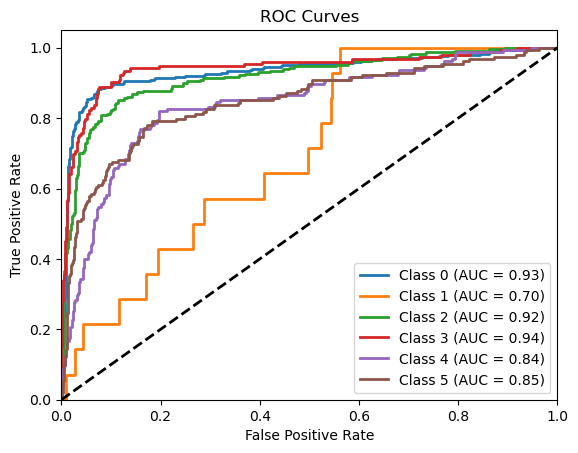

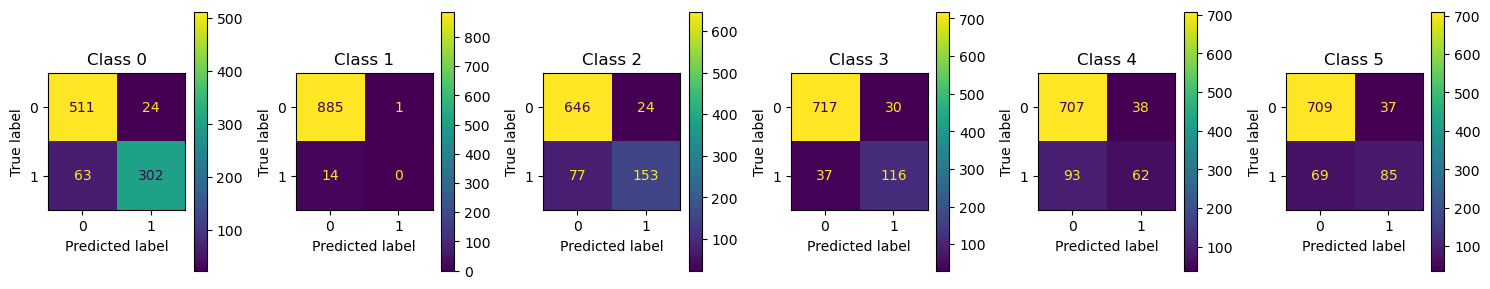


Probabilities for each row in the test set:
Row 1: Probs: [0.0036724049132317305, 0.002397647826001048, 0.0028694362845271826, 0.0025255591608583927, 0.0032435953617095947, 0.0041091302409768105] | Prediction: [0, 0, 0, 0, 0, 0] | Label: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0] | Result: True
Row 2: Probs: [0.003376253880560398, 0.002499873284250498, 0.0030752664897590876, 0.002565579256042838, 0.0029992179479449987, 0.0029388803523033857] | Prediction: [0, 0, 0, 0, 0, 0] | Label: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0] | Result: True
Row 3: Probs: [0.003231797134503722, 0.0022258423268795013, 0.0029876427724957466, 0.0026547948364168406, 0.0028489793185144663, 0.002962249331176281] | Prediction: [0, 0, 0, 0, 0, 0] | Label: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0] | Result: True
Row 4: Probs: [0.008076092228293419, 0.0036411115434020758, 0.004407262429594994, 0.003954749554395676, 0.00635162740945816, 0.00512632867321372] | Prediction: [0, 0, 0, 0, 0, 0] | Label: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0] | Result: True
Row 

In [39]:
if __name__ == "__main__":
    main(mode='test')